In [1]:
import pyvo as vo
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits


In [2]:
%matplotlib inline


In [3]:
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#define coordinates	
ra = 201.365
dec = -43.019
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')

In [4]:
# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")


In [61]:
#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
im_table

<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W4 Coadd 2022m425_ac51 ... 2022m425_ac51
W2 Coadd 2022m425_ac51 ... 2022m425_ac51
W1 Coadd 2022m425_ac51 ... 2022m425_ac51
W3 Coadd 2022m425_ac51 ... 2022m425_ac51

In [62]:
im_table.to_table().colnames

['sia_title',
 'sia_url',
 'cloud_access',
 'sia_naxes',
 'sia_fmt',
 'sia_ra',
 'sia_dec',
 'sia_naxis',
 'sia_crpix',
 'sia_crval',
 'sia_proj',
 'sia_scale',
 'sia_cd',
 'sia_bp_id',
 'sia_bp_ref',
 'sia_bp_hi',
 'sia_bp_lo',
 'sia_bp_unit',
 'magzp',
 'magzpunc',
 'unc_url',
 'cov_url',
 'coadd_id']

In [63]:
im_table.to_table()['sia_bp_id']
# i believe this gives us the different bandpasses that you can view the image in. 

W4
W2
W1
W3


In [64]:
for i in range(len(im_table)):
    print(im_table[i])

('W4 Coadd 2022m425_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/20/2022/2022m425_ac51/2022m425_ac51-w4-int-3.fits', '{"aws": {"bucket_name": "nasa-irsa-wise", "key":"wise/allwise/images/p3am_cdd/20/2022/2022m425_ac51/2022m425_ac51-w4-int-3.fits", "region": "us-west-2"}}', 2, 'image/fits', 202.248532, -42.404444, array([4095, 4095], dtype=int32), array([2048., 2048.]), array([202.248532, -42.404444]), 'SIN', array([-0.00038194,  0.00038194]), array([-0.00038194, -0.        , -0.        ,  0.00038194]), 'W4', 2.209e-05, 2.336e-05, 1.984e-05, 'm', 13.0, 0.012, 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/20/2022/2022m425_ac51/2022m425_ac51-w4-unc-3.fits.gz', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/20/2022/2022m425_ac51/2022m425_ac51-w4-cov-3.fits.gz', '2022m425_ac51')
('W2 Coadd 2022m425_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/20/2022/2022m425_ac51/2022m425_ac51-w2-int-3.fits', '{"aws": {"bucket_n

In [65]:
#search for the image in the W3 band image
# using a for loop i assume because it may be printed multiple times maybe?
# i printed it above, it could just be because the ID of the one object is printed 4 times due to there being 4 bandpasses but if you define it at W3 not sure why this is all necessary

for i in range(len(im_table)):
    if im_table[i]['sia_bp_id'] == 'W3':
        break
print(im_table[i].getdataurl())
# ahh yes, so the it runs over the "i" in the dataset until it finds W3 and then stops 
# so using "break" makes the for loop stop after it finds the ID of the object inside of W3
# this is prolly very useful if i am looking for multiple objects.

https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/20/2022/2022m425_ac51/2022m425_ac51-w3-int-3.fits


In [66]:
#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)

In [67]:
#extract a cutout and plot it
wcs = WCS(image1[0].header)
wcs


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.248532  -42.404444  
CRPIX : 2048.0  2048.0  
NAXIS : 4095  4095

In [68]:
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image1[0].data, pos, (60, 60), wcs=wcs)
wcs = cutout.wcs

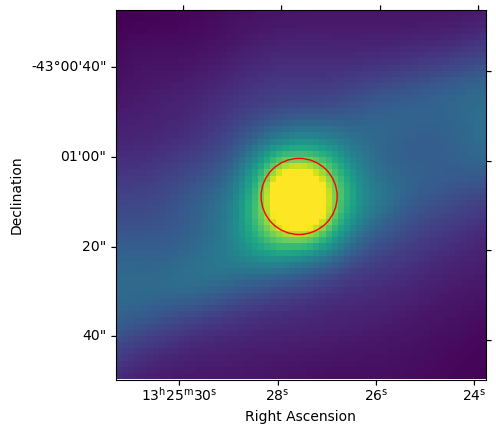

In [96]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection = wcs)

ax.imshow(cutout.data, origin='lower', vmax = 4000)

ax.scatter(ra, dec, transform= ax.get_transform('fk5'), facecolor= 'None', s=3000, edgecolor = 'red', alpha = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"